1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

За основу взят код из методички.

Критерии останова реализованы в функции build_tree

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [4]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

In [5]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [6]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_in_leaf):
    
    #  обозначим минимальное количество объектов в узле
    # min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_in_leaf or len(false_data) < min_in_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
# Построение дерева с помощью рекурсивной функции

"""Сделан ряд улучшений:
    1. min_in_leaf перенесен в гиперпараметры
    2. Добавлен критерий останова по глубине дерева - гиперпараметр max_levels
    3. Добавлен критерий останова по минимальному приросту качества - гиперпараметр min_quality_gain"""

def build_tree(data, labels, max_levels, min_in_leaf, min_quality_gain=0, current_level=0):

    quality, t, index = find_best_split(data, labels, min_in_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #if quality == 0:
    #    return Leaf(data, labels)

    if quality <= min_quality_gain:
        print(f'quality={quality} on level {current_level} for feature index={index} with t={t} is less than min_quality_gain - make a Leaf here')
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    current_level += 1

    if current_level == max_levels:
        return Leaf(data, labels)   
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_levels, min_in_leaf, min_quality_gain=min_quality_gain, current_level=current_level)
    false_branch = build_tree(false_data, false_labels, max_levels, min_in_leaf, min_quality_gain=min_quality_gain, current_level=current_level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [9]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [10]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [11]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, n_samples = 5000,
                                                      n_classes = 2, n_redundant=0, flip_y=0.2,
                                                      n_clusters_per_class=2, random_state=5)

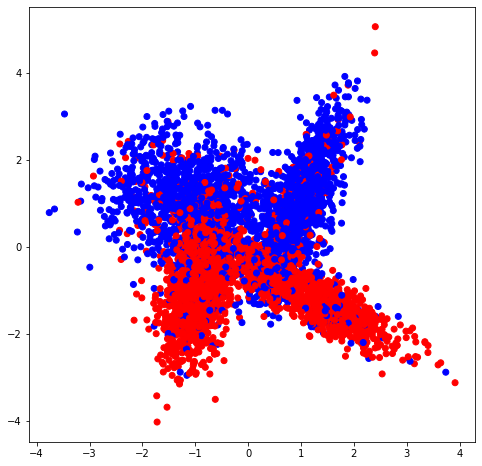

In [12]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [13]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_levels=4, min_in_leaf=5, min_quality_gain=0.02)

quality=0.001706638027320212 on level 2 for feature index=0 with t=-0.6565202330632472 is less than min_quality_gain - make a Leaf here
quality=0.017445656995829978 on level 3 for feature index=1 with t=0.036300895296002 is less than min_quality_gain - make a Leaf here
quality=0.0033934431865661613 on level 2 for feature index=0 with t=0.5794535914579055 is less than min_quality_gain - make a Leaf here


In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.00668287230856468
--> True:
  Индекс 1
  Порог -0.7147051650739367
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог 0.13605090128551323
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 1
  Порог 0.506378499240081
  --> True:
    Индекс 0
    Порог -0.03981809933100955
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

81.42857142857143

In [22]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

83.06666666666666

Text(0.5, 1.0, 'Test accuracy=83.07')

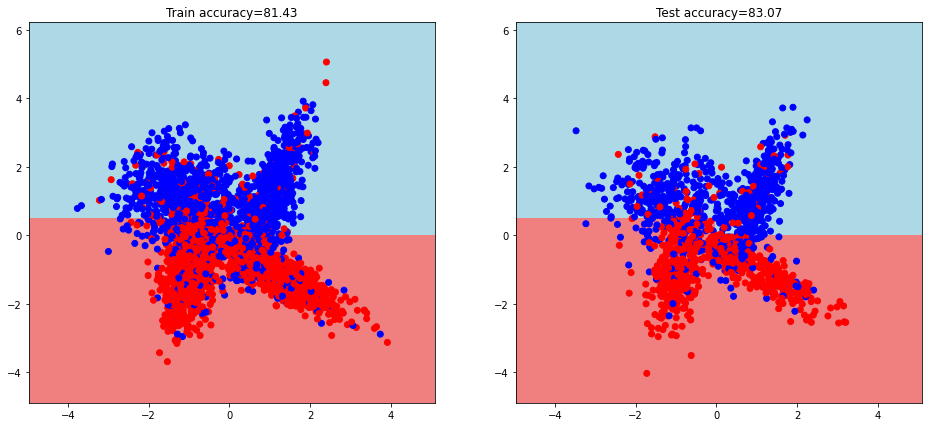

In [23]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [24]:
#создаем функцию подсчета  энтропии
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity += p * np.log2(p)
    impurity = (-1) * impurity
    return impurity

In [25]:
# добавляем в функцию подсчета функционала качества новый аргумент quality_criteria, чтобы его можно было определять при вызове функции
def quality(left_labels, right_labels, current_criteria_value, quality_criteria):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criteria_value - p * quality_criteria(left_labels) - (1 - p) * quality_criteria(right_labels)

In [26]:
# добавляем аргумент quality_criteria и в эту функцию
def find_best_split(data, labels, min_in_leaf, quality_criteria):    
    
    current_criteria_value = quality_criteria(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_in_leaf or len(false_data) < min_in_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criteria_value, quality_criteria)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [27]:
# добавляем аргумент quality_criteria и в эту функцию
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_levels, min_in_leaf, quality_criteria, min_quality_gain=0, current_level=0, ):

    quality, t, index = find_best_split(data, labels, min_in_leaf, quality_criteria)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #if quality == 0:
    #    return Leaf(data, labels)

    if quality <= min_quality_gain:
        print(f'quality={quality} on level {current_level} for feature index={index} with t={t} is less than min_quality_gain - make a Leaf here')
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    current_level += 1

    if current_level == max_levels:
        return Leaf(data, labels)   
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_levels, min_in_leaf, quality_criteria, min_quality_gain=min_quality_gain, current_level=current_level)
    false_branch = build_tree(false_data, false_labels, max_levels, min_in_leaf, quality_criteria, min_quality_gain=min_quality_gain, current_level=current_level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Укажем в качестве аргумента quality_criteria=entropy

In [28]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_levels=4, min_in_leaf=5, min_quality_gain=0.02, quality_criteria=entropy)

quality=0.006190091323191371 on level 2 for feature index=0 with t=-0.6565202330632472 is less than min_quality_gain - make a Leaf here
quality=0.011525315992392149 on level 2 for feature index=0 with t=0.5794535914579055 is less than min_quality_gain - make a Leaf here


In [29]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.00668287230856468
--> True:
  Индекс 1
  Порог -0.7147051650739367
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог 0.13605090128551323
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 1
  Порог 0.506378499240081
  --> True:
    Индекс 0
    Порог -0.03981809933100955
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 1


In [30]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [31]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [32]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

81.42857142857143

In [33]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

83.06666666666666

Разбиение по критерию Джини было в первом задании. Изменение критерия информативности не повлияло на итоговый результат модели. Т.е. критерии отработали примерно идентично на этих данных. Но обращает внимание, что показатель энтропии распределен менее плотно (от 0 до 1), а Джини более плотно (от 0 до 0.5). Этот момент нужно учитывать для определения гипепараметра, который отвечает за критерий останова при маленьком приросте качества. Так при значении min_quality_gain=0.02 в модели с Джини при построении дерева было 3 случая останова по этому параметру, при использовании энтропии - 2 останова.

**3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [45]:
# внесем изменение в метод predict - прогноз будет делаться как взятие среднего по выборке в листе
#класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):   
        prediction = np.mean(self.labels)
        return prediction 

In [46]:
# создадим функцию посчета дисперсии выборки, которую будем передавать в аргументе quality_criteria
def variance(labels):
    return np.var(labels)

In [41]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_features = 2, n_informative = 2, n_samples = 5000,
                                                       random_state=5)

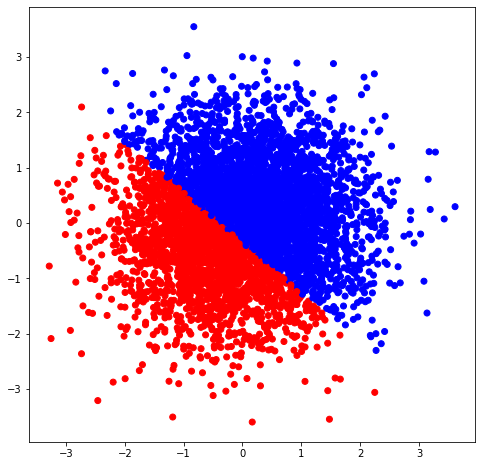

In [47]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], regression_data)), list(map(lambda x: x[1], regression_data)), 
              c=regression_labels, cmap=colors)

In [43]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [114]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_levels=6, min_in_leaf=15, min_quality_gain=10, quality_criteria=variance)

quality=0 on level 5 for feature index=None with t=None is less than min_quality_gain - make a Leaf here
quality=0 on level 5 for feature index=None with t=None is less than min_quality_gain - make a Leaf here
quality=0 on level 5 for feature index=None with t=None is less than min_quality_gain - make a Leaf here
quality=0 on level 5 for feature index=None with t=None is less than min_quality_gain - make a Leaf here
quality=0 on level 5 for feature index=None with t=None is less than min_quality_gain - make a Leaf here
quality=0 on level 5 for feature index=None with t=None is less than min_quality_gain - make a Leaf here


In [115]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.009317198082839291
--> True:
  Индекс 0
  Порог -0.11368228421560567
  --> True:
    Индекс 1
    Порог -0.9927694461542396
    --> True:
      Индекс 0
      Порог -1.092682997075172
      --> True:
        Индекс 1
        Порог -1.941575032205066
        --> True:
          Прогноз: -152.87610810512973
        --> False:
          Прогноз: -106.13004768589796
      --> False:
        Индекс 1
        Порог -1.8639302724108073
        --> True:
          Прогноз: -103.44763960041583
        --> False:
          Прогноз: -69.4059721085931
    --> False:
      Индекс 0
      Порог -1.1663502086637008
      --> True:
        Индекс 0
        Порог -1.9951406007690835
        --> True:
          Прогноз: -94.34318993989054
        --> False:
          Прогноз: -66.86949533287756
      --> False:
        Индекс 1
        Порог -0.45202904228241764
        --> True:
          Прогноз: -45.89680539581779
        --> False:
          Прогноз: -29.609617022980906
  --> False:

In [116]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [117]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [88]:
# функция подсчета MSE
def mse(y_true, y_pred):
    return (np.sum(y_true-y_pred)**2)/len(y_true)

In [118]:
# MSE на обучающей выборке
train_mse = mse(train_labels, train_answers)
train_mse

1.6825186008681842e-28

In [119]:
# MSE на тестовой выборке
test_mse = mse(test_labels, answers)
test_mse

19.226220556533672

Text(0.5, 1.0, 'Test mse=19.23')

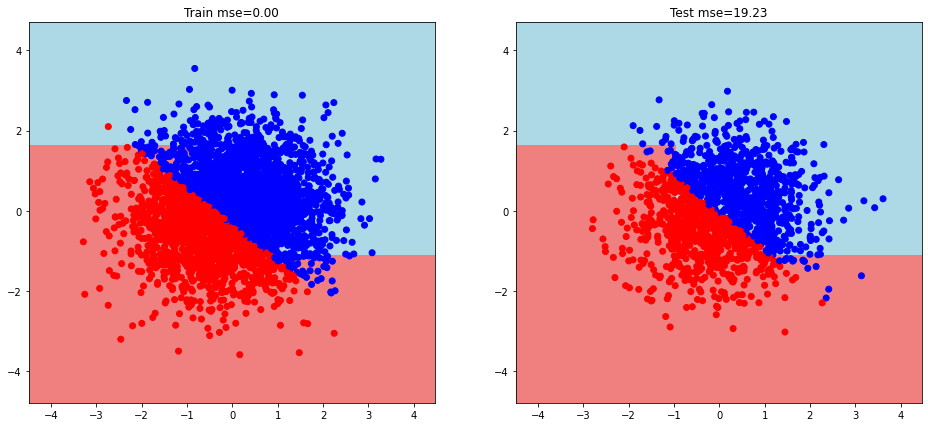

In [120]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train mse={train_mse:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test mse={test_mse:.2f}')